In [11]:
# Examine SBGC results
#from netCDF4 import Dataset as NetCDFFile
import math
import numpy as np
import pandas as pd
import isamcalc_lib as isam
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy.ma as ma
from scipy.interpolate import griddata
import copy
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

In [12]:
## Check NPP/Rh
# Open site output
path='/global/cscratch1/sd/sshu3/SBGC/site/rh_eval/'
site='boreal_2396/'
fname='site_daily_1_met.txt'
obs_fname=path+site+fname
data = pd.read_csv(obs_fname,delim_whitespace=True,header=None)
at_boreal = data.values[:,0]
pr_boreal = data.values[:,1]
srad_boreal = data.values[:,2]
lrad_boreal = data.values[:,3]

fname='site_daily_9_soilt.txt'
obs_fname=path+site+fname
data = pd.read_csv(obs_fname,delim_whitespace=True,header=None)
st_boreal = data.values[:,5:15]
#snow_boreal = data.values[:,0:5]
#snow_boreal[sw_boreal<=0] = np.float('nan')

fname='site_daily_7_watice.txt'
obs_fname=path+site+fname
data = pd.read_csv(obs_fname,delim_whitespace=True,header=None)
ice_boreal = data.values[:,5:15]

fname='site_daily_8_watliq.txt'
obs_fname=path+site+fname
data = pd.read_csv(obs_fname,delim_whitespace=True,header=None)
sm_boreal = data.values[:,5:15]

fname='resp.txt'
obs_fname=path+site+fname
data = pd.read_csv(obs_fname,delim_whitespace=True,header=None)
rh_boreal = data.values[:,0:10]

fname='site_daily_4_energy.txt'
obs_fname=path+site+fname
data = pd.read_csv(obs_fname,delim_whitespace=True,header=None)
grndf_boreal = data.values[:,8]


In [38]:
np.shape(ice_boreal)

(56575, 10)

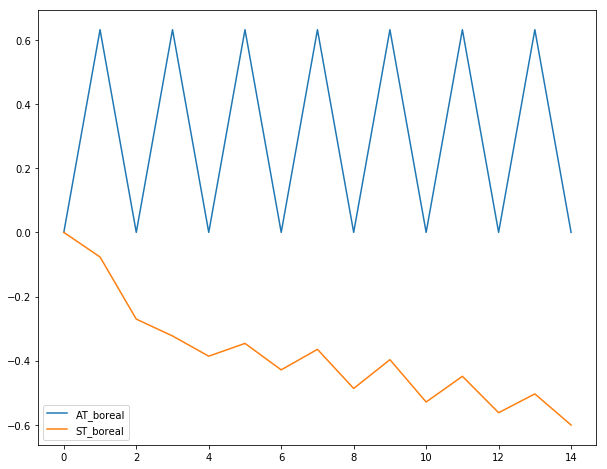

In [3]:
# Check summer time Air/Soil T
soilt_boreal = np.zeros((np.shape(st_boreal[:,0:8])[0]))

# Calcualte the 1-m mean SoilT
for i in np.arange(0,np.shape(st_boreal[:,0:8])[0]):
    soilt_boreal[i] = isam.avg_wt_1m_soil([1,1,1,1,1,1,1,1], st_boreal[i,0:8])

# Calculate the mean of every years
at_boreal_series = np.zeros((150))
st_boreal_series = np.zeros((150))

# Summer only
for t in np.arange(0,150):
    at_boreal_series[t] = np.mean(at_boreal[(t*365+150):(t*365+220)])
    st_boreal_series[t] = np.mean(soilt_boreal[(t*365+150):(t*365+220)])
    
# Get every 10 years for summer
at_boreal_decade = np.zeros((15))
st_boreal_decade = np.zeros((15))
for t in np.arange(0,15):
    # Summer only
    at_boreal_decade[t] = np.mean(at_boreal_series[(t*10):(t*10+10)])
    st_boreal_decade[t] = np.mean(st_boreal_series[(t*10):(t*10+10)])

# Decadal plot of summer mean
plt.figure(figsize=(10,8))
#plt.ylim([-1.5,1.5])
plt.plot(at_boreal_decade - at_boreal_decade[0])
plt.plot(st_boreal_decade - st_boreal_decade[0])
plt.legend(['AT_boreal', 'ST_boreal'])

In [4]:
# Calculate the mean soil temperature by using respiration as weight
# Need to transfer Rh from per week to per day
rh_boreal_daily = np.zeros((np.shape(st_boreal)[0],10))
for i in np.arange(0,np.shape(rh_boreal)[0]):
    yr = i // 52
    if(i % 52 == 0):
        rh_boreal_daily[(i*7+yr):(i*7+yr+8),:] = 1000.*rh_boreal[i,:]/7.
    else:
        rh_boreal_daily[(i*7+yr):(i*7+yr+7),:] = 1000.*rh_boreal[i,:]/7.

rh1m_boreal = np.zeros((np.shape(rh_boreal_daily)[0]))

# Calcualte the 1-m mean Respiration
for i in np.arange(0,np.shape(st_boreal[:,0:8])[0]):
    rh1m_boreal[i] = isam.agg_1m_soil(rh_boreal_daily[i,0:8])

# Calculate decadal mean of Rh for checking
rh_boreal_decade = np.zeros((15))

for t in np.arange(0,15):
    rh_boreal_decade[t] = np.mean(rh1m_boreal[(t*3650):(t*3650+3650)])

# Use the resp as weight to calculate vertical mean
soilt_boreal = np.zeros((np.shape(st_boreal)[0]))

# Calcualte the 1-m mean SoilT
for i in np.arange(0,np.shape(st_boreal)[0]):
    soilt_boreal[i] = isam.avg_wt_1m_soil(rh_boreal_daily[i,0:8]+1e-4, st_boreal[i,0:8])
    
# Calculate the mean of every years, also using the respiration as weight
st_boreal_series = np.zeros((150))

for t in np.arange(0,150):
    st_boreal_series[t] = np.dot(soilt_boreal[(t*365):(t*365+365)],rh1m_boreal[(t*365):(t*365+365)]) \
                                  / np.sum(rh1m_boreal[(t*365):(t*365+365)])
    
# Get every 10 years for summer
st_boreal_decade = np.zeros((15))
for t in np.arange(0,15):
    st_boreal_decade[t] = np.nanmean(st_boreal_series[(t*10):(t*10+10)])


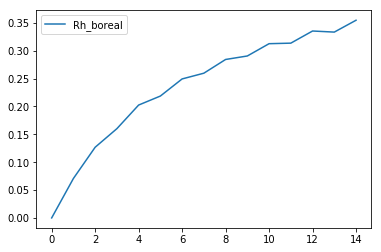

In [5]:
# Check the seasonality of Rh
plt.plot(rh_boreal_decade - rh_boreal_decade[0])

plt.legend(['Rh_boreal'])

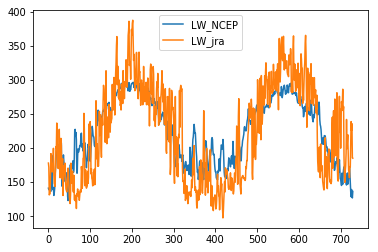

In [30]:
## Following are codes for examine every Rh sites